# Sign Language Dataset

The Sign Language Dataset consists of 9680 grayscale images of hand signs for the digits 0-9 and the alphabets a-z. Thus, this is a multiclass classification problem with 36 classes. Your task is to build a machine learning model that can accurately classify images from this dataset.

## Loading the Data

Let's take a look at the statistics of the dataset (number of images per class) and some sample images from each class. Utility functions for this purpose are provided to you.

In [1]:
import os
import csv
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /var/folders/9l/hc6vjb_16sj0br4xnxqpwcxw0000gn/T/matplotlib-wtl7qooe because the default path (/Users/thomas/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Location of the dataset
data_dir = "sign_lang_train"

In [3]:
# Utility functions

def write_csv(write_list, file_name):
    with open(file_name,'w') as out:
        write = csv.writer(out)
        write.writerows(write_list)
        
def read_csv(csv_file):
    with open(csv_file, newline='') as f:
        reader = csv.reader(f)
        data = list(reader)
    return data

def create_dict_from_list(tuple_list):
    dict_list = {}
    for x, y in tuple_list:
        dict_list.setdefault(x, []).append(y)
    return dict_list

In [4]:
# Plot sample data for each class
def plot_samples(label_dict, data_dir, num_samples=10):
    
    num_classes = len(label_dict.keys())
    fig, ax = plt.subplots(num_classes, num_samples, figsize=(20,60))
    
    for row, class_name in enumerate(sorted(label_dict.keys())):
        
        image_file_list = label_dict[class_name]
        
        random.shuffle(image_file_list)
        samples = image_file_list[0:num_samples]
        
        for col in range(num_samples):
            if col==0:
                ax[row][col].set_ylabel(f"Class: {class_name}")
            image_path = os.path.join(data_dir, samples[col])
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)
            ax[row][col].imshow(image)
            
    plt.tight_layout()

In [5]:
# Data statistics for train and test sets
train_label_file = os.path.join(data_dir, "labels.csv")
train_list = read_csv(train_label_file)
train_dict = create_dict_from_list(train_list)

<BarContainer object of 36 artists>

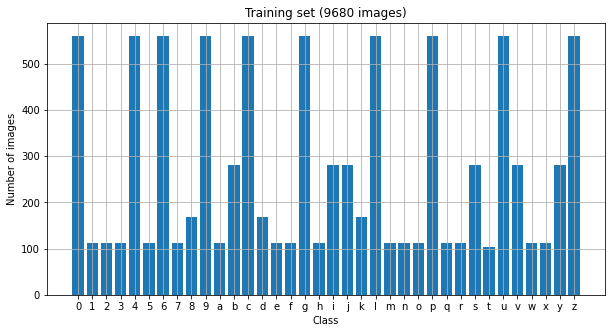

In [6]:
total_train = 0
for k in sorted(train_dict.keys()):
    total_train += len(train_dict[k])
    
plt.figure(figsize=(10,5))
plt.grid()
plt.ylabel("Number of images")
plt.xlabel("Class")
plt.title(f"Training set ({total_train} images)")
plt.bar(sorted(train_dict.keys()), [len(train_dict[k]) for k in sorted(train_dict.keys())])

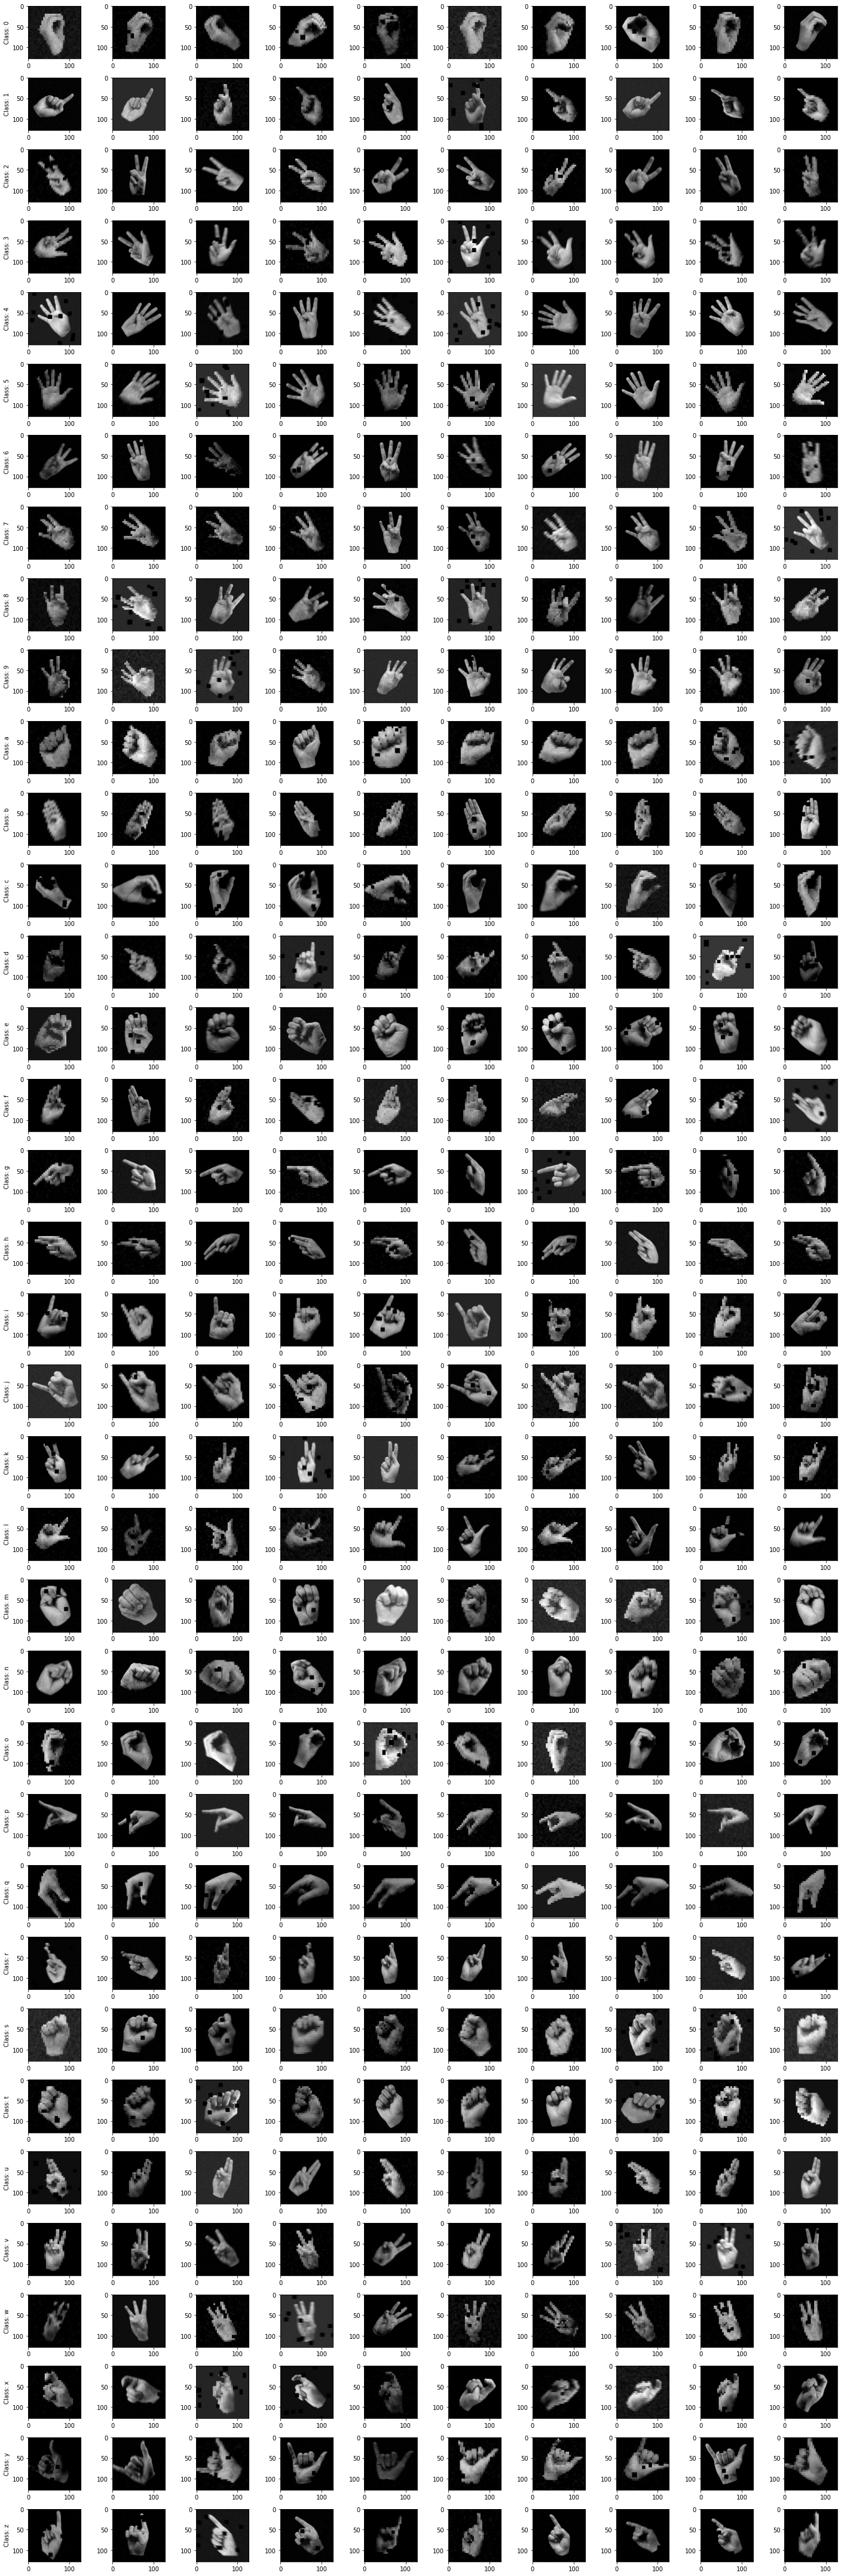

In [7]:
# Plot samples from the training set
plot_samples(train_dict, data_dir, num_samples=10)

## Data Loading using PyTorch

For creating and training your model, you can work with any machine learning library of your choice. 

If you choose to work with [PyTorch](https://pytorch.org/), you will need to create your own [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class for loading the data. This is provided below. See [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) for a nice example of how to create a custom data loading pipeline in PyTorch. 

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, io
from torchvision.utils import make_grid

from string import ascii_lowercase

In [9]:
class SignLangDataset(Dataset):
    """Sign language dataset"""

    def __init__(self, csv_file, root_dir, class_index_map=None, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = read_csv(os.path.join(root_dir,csv_file))
        self.root_dir = root_dir
        self.class_index_map = class_index_map
        self.transform = transform
        # List of class names in order
        self.class_names = list(map(str, list(range(10)))) + list(ascii_lowercase)

    def __len__(self):
        """
        Calculates the length of the dataset-
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns one sample (dict consisting of an image and its label)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read the image and labels
        image_path = os.path.join(self.root_dir, self.data[idx][1])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # Shape of the image should be H,W,C where C=1
        image = np.expand_dims(image, 0)
        # The label is the index of the class name in the list ['0','1',...,'9','a','b',...'z']
        # because we should have integer labels in the range 0-35 (for 36 classes)
        label = self.class_names.index(self.data[idx][0])
                
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [10]:
# Create a Dataset object
sign_lang_dataset = SignLangDataset(csv_file="labels.csv", root_dir=data_dir)

# Size of the entire dataset
data_len = len(sign_lang_dataset)
print(f"Size of the dataset: {data_len} images")

Size of the dataset: 9680 images


It is generally a good idea to divide the dataset into a training set (which will be used for training the model) and a validation set (for evaluating the model's performance). Use of the validation set is necessary for finding good hyperparameters and also for making sure that your model does not overfit on the training samples.

Provided below is some sample code that you can use for splitting the dataset into a training set and a validation set.

In [11]:
# What percentage of the dataset to use for training
# The remaining images will go into the validation set
train_ratio = 0.8

# Calculate the size of the training and validation sets
train_size = int(train_ratio * data_len)
val_size = data_len - train_size

After calculating the number of images for the training and validation sets, we need to create separate `Dataset` objects for each set. This is done using the `random_split` function.
These `Dataset` objects are then used to create `Dataloader` objects which are used for loading the images and labels in batches during training.

In [12]:
# Create Dataset objects for training and validation
train_dataset, val_dataset = random_split(sign_lang_dataset, [train_size, val_size])

# Create Dataloader objects for training and validation
train_dataloader = DataLoader(train_dataset, 
                              batch_size=64,
                              shuffle=True, 
                              num_workers=0)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=64,
                            shuffle=True, 
                            num_workers=0)

Now let's use the training `Dataloader` object to load and display a batch of images. Note that since we use a `batch_size` of 64, and each image has 1 channel and its height and width are both 128, the shape of a batch is [64,1,128,128] (number of images, channels, height, width).

Shape of a batch of images: torch.Size([64, 1, 128, 128])
Labels: tensor([ 6, 11, 23, 14,  0, 27,  9, 25, 33,  9, 30, 21, 17,  6, 18, 20,  3, 33,
        19, 21, 34,  1, 20, 16, 30, 35, 16, 14, 29, 26, 35,  8,  8,  9, 18, 18,
         4, 22, 31, 30,  6, 19,  6, 30,  4,  6, 35, 17, 11,  5,  0,  4,  4,  6,
         9,  6, 25,  4, 12,  9, 16, 13, 29, 21])


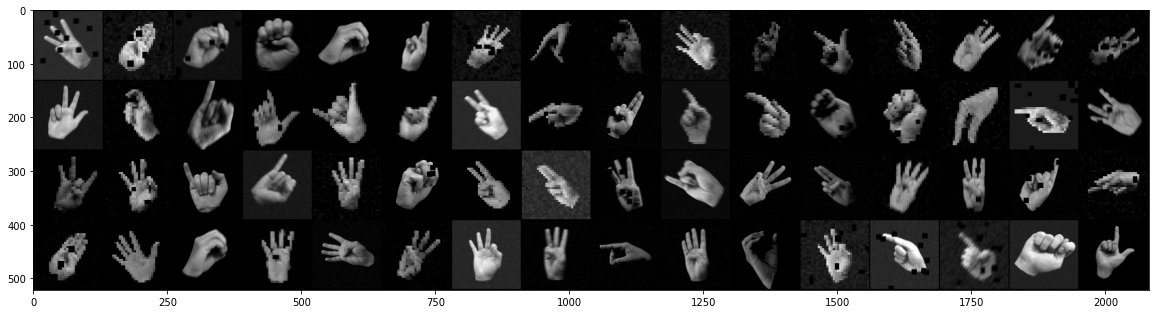

In [13]:
# Display a batch of training data
for sample in train_dataloader:
    x = sample["image"]
    y = sample["label"]
    grid_img = make_grid(x, nrow=16)
    plt.figure(figsize=(20,20))
    plt.imshow(grid_img.permute(1,2,0))
    print(f"Shape of a batch of images: {x.shape}")
    print(f"Labels: {y}")
    break

## Prediction Stub

You will need to provide a function that can be used to make predictions using your final trained model. 

**IMPORTANT**

1. The name of your prediction function must be `leader_board_predict_fn`
2. Your prediction function should be able take as input a 4-D numpy array of shape [batch_size,1,128,128] and produce predictions in the form of a 1-D numpy array of shape [batch_size,]. 
3. Predictions for each image should be an integer in the range 0-35, that is `0` for the digit $0$, `1` for the digit $1$, .... , `9` for the digit $9$, `10` for the letter $a$, `11` for the letter $b$, ..., `35` for the letter $z$.
4. Your prediction function should internally load your trained model and take care of any data transformations that you need.

Below we provide a dummy prediction function that always predicts the class `4` for any image. Your `leader_board_predict_fn` function should have the same function signature (same input and output types and shapes) but obviously should be better at making predictions!

In [14]:
 def leader_board_predict_fn(input_batch):
    """
    Function for making predictions using your trained model.
    
    Args:
        input_batch: Input images (4D numpy array of shape [batch_size, channels, height, width])
        
    Returns:
        output: Predictions of the your trained model (1D numpy array of integers (0-35) of shape [batch_size, ])
    """
    
    batch_size, channels, height, width = input_batch.shape
    
    # Here we make the same predictions for all the images
    # You should replace the below line with code to load your model
    # and make predictions using your trained model
    output = np.array([4]*batch_size)
    
    return output

## Evaluation

Your final model will be evaluated on a hidden test set containing images similar to the dataset that you are provided with.

For evaluating the performance of your model, we will use the normalized [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) metric from sklearn. This is simply the percentage of correct predictions that your model makes for all the images of the hidden test set. Hence, if all the predictions are correct, the score is 1.0 and if all predictions are incorrect, the score is 0.0. We will use the sklearn metric so that the accuracy function is agnostic to the machine learning framework you use.

Let's create some dummy data for evaluation.

In [15]:
num_batches = 10
batch_size = 64
channels = 1
height = 128
width = 128
num_classes = 36

# Create some dummy input data and labels
dummy_images = np.random.rand(num_batches, batch_size, channels, height, width)
dummy_labels = np.random.randint(low=0, high=num_classes, size=(num_batches, batch_size))

Using our dummy prediction function, let's calculate the classification accuracy. The leaderboard rank will be determined in a way similar to this:

In [16]:
### LEADER BOARD TEST

from sklearn.metrics import accuracy_score

def accuracy(images, labels):
    """
    Calculates the average prediction accuracy.
    
    Args:
        images: Input images (5D numpy array of shape [num_batches, batch_size, channels, height, width])
        labels: True labels for the images (2D numpy array of integers (0-35) of shape [num_batches, batch_size])
        
    Returns:
        accuracy: Average accuracy score over all images (float in the range 0.0-1.0)
    """
    
    num_batches, batch_size, _, _, _ = images.shape
    
    accuracy = 0.0
    
    for batch in range(num_batches):
        
        y_pred = leader_board_predict_fn(images[batch])
        y_true = labels[batch]
        
        assert y_pred.shape == (batch_size,), f"Shape of predictions {y_pred.shape} should be {(batch_size,)}"
        assert y_true.shape == (batch_size,), f"Shape of labels {y_true.shape} should be {(batch_size,)}"
        
        accuracy += accuracy_score(y_true, y_pred, normalize=True)
        
    accuracy /= num_batches
    
    return accuracy  

# Calculate the average accuracy over all batches
# accuracy function calls your leader_board_predict_fn internally
acc=accuracy(dummy_images, dummy_labels)

### LEADER BOARD TEST

print(f"Accuracy = {acc}")


Accuracy = 0.03125


Using this naive classifier, we get a very low accuracy score.